## Imports 

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import BayesianRidge




## Cargar data 

In [2]:

elo = pd.read_csv('../data/EloRatings.csv')
matches = pd.read_csv('../data/Matches.csv')

/tmp/ipykernel_1739/990902480.py:2: DtypeWarning: Columns (0: MatchTime) have mixed types. Specify dtype option on import or set low_memory=False.
  matches = pd.read_csv('../data/Matches.csv')


In [3]:
elo.head(20)

,date,club,country,elo
0,2000-07-01,Aachen,GER,1453.60
1,2000-07-01,Aalborg,DEN,1482.61
2,2000-07-01,Aalst,BEL,1337.53
3,2000-07-01,Aarhus,DEN,1381.46
4,2000-07-01,Aberdeen,SCO,1360.43
5,2000-07-01,Adanaspor,TUR,1380.76
6,2000-07-01,AEK,GRE,1599.31
7,2000-07-01,AIK,SWE,1563.87
8,2000-07-01,Ajaccio,FRA,1470.87
9,2000-07-01,Ajax,NED,1604.75


In [4]:
matches.head(20)

,Division,MatchDate,MatchTime,HomeTeam,AwayTeam,HomeElo,AwayElo,Form3Home,Form5Home,Form3Away,...,MaxUnder25,HandiSize,HandiHome,HandiAway,C_LTH,C_LTA,C_VHD,C_VAD,C_HTB,C_PHB
0,F1,2000-07-28,NaN,Marseille,Troyes,1686.34,1586.57,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F1,2000-07-28,NaN,Paris SG,Strasbourg,1714.89,1642.51,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F2,2000-07-28,NaN,Wasquehal,Nancy,1465.08,1633.80,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,F1,2000-07-29,NaN,Auxerre,Sedan,1635.58,1624.22,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,F1,2000-07-29,NaN,Bordeaux,Metz,1734.34,1673.11,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,F1,2000-07-29,NaN,Guingamp,St Etienne,1578.51,1620.74,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,F1,2000-07-29,NaN,Lille,Monaco,1630.81,1778.03,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,F1,2000-07-29,NaN,Lyon,Rennes,1702.60,1644.99,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,F1,2000-07-29,NaN,Nantes,Lens,1664.36,1730.89,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,F1,2000-07-29,NaN,Toulouse,Bastia,1551.65,1656.37,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Union de los dos dataset: 

In [5]:
# 2. Convertir fechas (Paso critico para evitar errores previos)
matches['MatchDate'] = pd.to_datetime(matches['MatchDate'])
elo['date'] = pd.to_datetime(elo['date'])

matches = matches.sort_values('MatchDate')
elo = elo.sort_values('date')

# 4. Unir para el Equipo LOCAL
df = pd.merge_asof(
    matches,
    elo,
    left_on='MatchDate',
    right_on='date',
    left_by='HomeTeam',
    right_by='club',
    direction='backward'
 )

# Renombramos la columna para que no se confunda con la del visitante
df = df.rename(columns={'elo': 'Homeelo'})

# 5. Unir para el Equipo VISITANTE
df = pd.merge_asof(
    df,
    elo,
    left_on='MatchDate',
    right_on='date',
    left_by='AwayTeam',
    right_by='club',
    direction='backward'
 )

df = df.rename(columns={'elo': 'Awayelo'})

# # Limpieza: Borrar columnas repetidas de la union
# df = df.drop(columns=['date_x', 'club_x', 'date_y', 'club_y', 'country_x', 'country_y'], errors='ignore')

print(df[['MatchDate', 'HomeTeam', 'AwayTeam', 'Homeelo', 'Awayelo']].head())

   MatchDate   HomeTeam    AwayTeam  Homeelo  Awayelo
0 2000-07-28  Marseille      Troyes  1686.34  1586.57
1 2000-07-28   Paris SG  Strasbourg  1714.89  1642.51
2 2000-07-28  Wasquehal       Nancy  1465.08  1633.80
3 2000-07-29      Niort      Angers  1469.16  1422.21
4 2000-07-29      Nimes     Sochaux  1449.91  1575.12


## Visualización 

In [6]:
print('Data shape:', df.shape)
print(df.info())

Data shape: (230557, 56)
<class 'pandas.DataFrame'>
RangeIndex: 230557 entries, 0 to 230556
Data columns (total 56 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Division     230557 non-null  str           
 1   MatchDate    230557 non-null  datetime64[us]
 2   MatchTime    99072 non-null   str           
 3   HomeTeam     230557 non-null  str           
 4   AwayTeam     230557 non-null  str           
 5   HomeElo      141597 non-null  float64       
 6   AwayElo      141528 non-null  float64       
 7   Form3Home    229057 non-null  float64       
 8   Form5Home    229057 non-null  float64       
 9   Form3Away    229057 non-null  float64       
 10  Form5Away    229057 non-null  float64       
 11  FTHome       230554 non-null  float64       
 12  FTAway       230554 non-null  float64       
 13  FTResult     230554 non-null  str           
 14  HTHome       175977 non-null  float64       
 15  HTAway       175977 

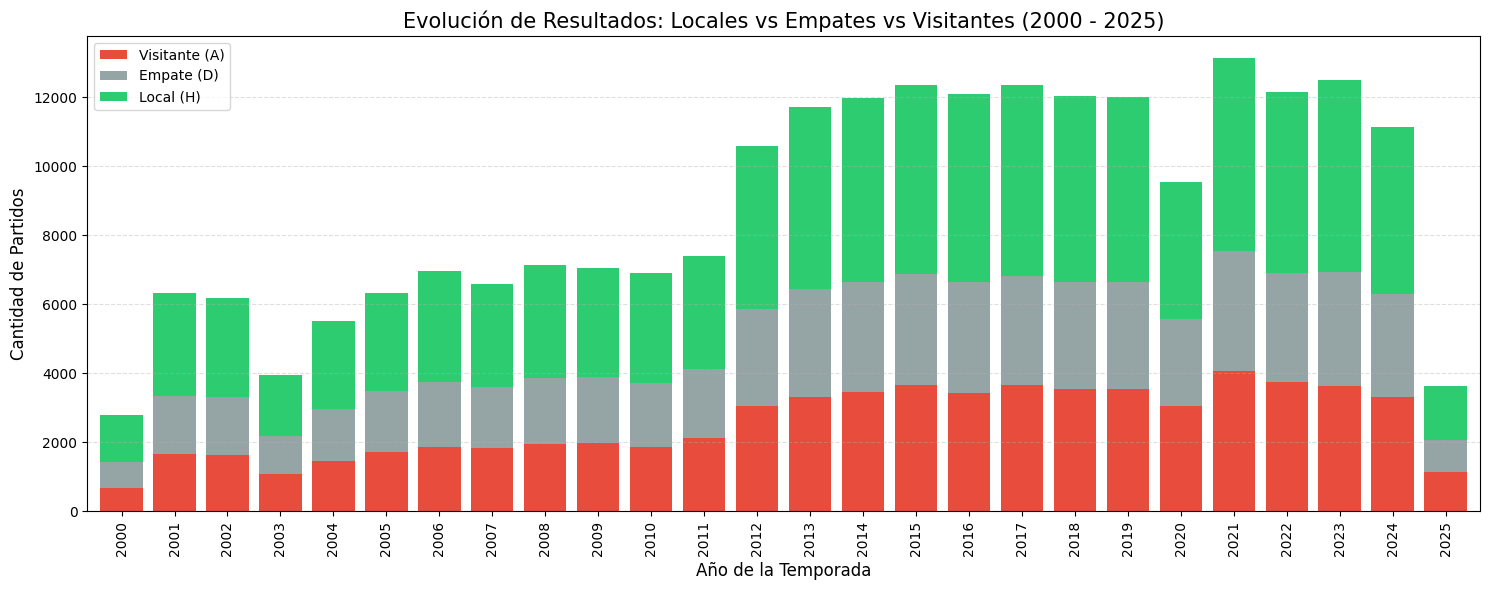

In [7]:

# 2. Conversión ROBUSTA a fecha (esto soluciona tu error)
# errors='coerce' convierte valores problemáticos en NaT (Not a Time)
df['MatchDate'] = pd.to_datetime(df['MatchDate'], errors='coerce')

# Eliminamos filas donde la fecha no se pudo procesar (limpieza básica)
df = df.dropna(subset=['MatchDate'])

# 3. Crear columna de Año para el análisis
df['Year'] = df['MatchDate'].dt.year

# 4. Configuración del Dashboard Profesional
plt.figure(figsize=(15, 6))

# --- GRÁFICO DE BARRAS: Resultados por década ---
# Agrupamos por año y resultado para ver tendencias
summary = df.groupby(['Year', 'FTResult']).size().unstack().fillna(0)

# Graficamos con colores profesionales
summary.plot(kind='bar', stacked=True, 
             color=['#e74c3c', '#95a5a6', '#2ecc71'], 
             ax=plt.gca(), width=0.8)

plt.title('Evolución de Resultados: Locales vs Empates vs Visitantes (2000 - 2025)', fontsize=15)
plt.xlabel('Año de la Temporada', fontsize=12)
plt.ylabel('Cantidad de Partidos', fontsize=12)
plt.legend(['Visitante (A)', 'Empate (D)', 'Local (H)'], loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


# Limpieza manual 

Breve introducción: a continuación he separado cada paso de la limpieza en celdas individuales (carga, eliminación de columnas constantes, duplicados, redundancias, clasificación, análisis de missing, eliminación por umbral, eliminación de filas con muchos missing, extracción de features y guardado). Ejecuta cada celda en orden y revisa los outputs antes de proceder a la siguiente celda.

### Valores constantes y duplicados:

In [8]:
# 1. Eliminar columnas constantes
const_cols = [col for col in df.columns if df[col].nunique() <= 1]
df.drop(columns=const_cols, inplace=True)

# 2. Eliminar columnas duplicadas 
df = df.loc[:, ~df.columns.duplicated()]

print(f"Columnas constantes eliminadas: {const_cols}")
print(f"Forma del dataset tras limpieza inicial: {df.shape}")

Columnas constantes eliminadas: []
Forma del dataset tras limpieza inicial: (230557, 57)


# Data leaked 
- Separamos los datos en antes del partido, durante el partido y post partido

In [13]:
#  1. ANTES DEL PARTIDO 
# Incluimos variable objetivo FTResult
cols_pre = [
    'Division', 'MatchDate', 'MatchTime', 'HomeTeam', 'AwayTeam', # identificación
    'HomeElo', 'AwayElo',                  # nivel de los equipos
    'Form3Home', 'Form5Home',              # Home ultimos 3/5 partidos 
    'Form3Away', 'Form5Away',              # Away ultimos 3/5 partidos 
    'OddHome', 'OddDraw', 'OddAway',       # Cuotas principales (b365)  
    'MaxHome', 'MaxDraw', 'MaxAway',       # Maximos del mercado 
    'Over25', 'Under25', 'MaxOver25', 'MaxUnder25',  # Cuotas de goles (+/- 2.5) / Maximos de cuotas de goles
    'HandiSize', 'HandiHome', 'HandiAway', # Handicap
    'FTResult' # Variable objetivo 
 ]

# --- 2. DURANTE EL PARTIDO 
cols_durante = [
    'HTHome', 'HTAway', 'HTResult',       # Goles y resultado al descanso
    'HomeShots', 'AwayShots',             # Tiros totales
    'HomeTarget', 'AwayTarget',           # Tiros a puerta
    'HomeFouls', 'AwayFouls',             # Faltas cometidas
    'HomeCorners', 'AwayCorners',         # Saques de esquina
    'HomeYellow', 'AwayYellow',           # Tarjetas amarillas
    'HomeRed', 'AwayRed',                 # Tarjetas rojas
 ]

# --- 3. POST-PARTIDO 
cols_post = [
    'FTHome', 'FTAway',                  # Goles finales exactos
    'C_LTH', 'C_LTA',                    # Ritmo bajo
    'C_VHD', 'C_VAD',                    # Dominio visible
    'C_HTB', 'C_PHB'                     # Ritmo alto
 ]

datos_pre = df[[c for c in cols_pre if c in df.columns]].copy()
datos_durante = df[[c for c in cols_durante if c in df.columns]].copy()
datos_post = df[[c for c in cols_post if c in df.columns]].copy()

print("Variables separadas correctamente.")

Variables separadas correctamente.


# Missing values 

<Axes: >

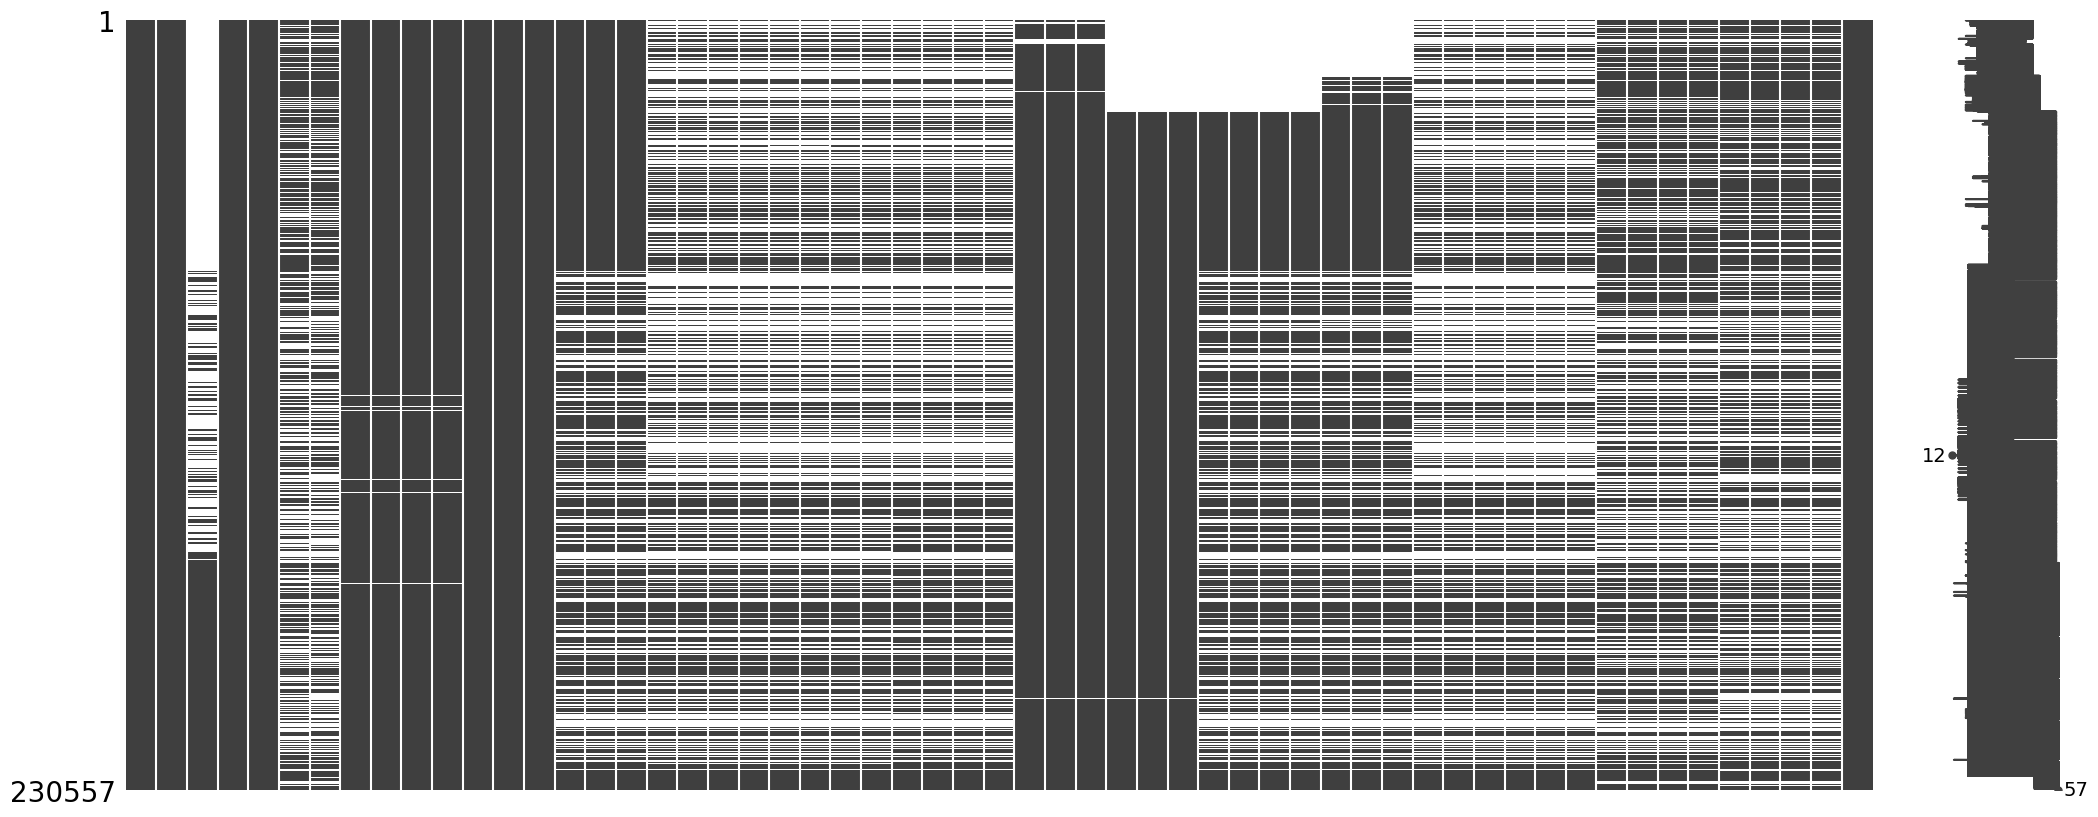

In [14]:
msno.matrix(df)

In [15]:
todas_las_columnas = [c for c in cols_pre + cols_durante + cols_post if c in df.columns]

# 2. Análisis de nulos
print("--- ANÁLISIS DE HUECOS EN EL DATASET ---")
missing_data = df[todas_las_columnas].isnull().sum()
missing_percent = (missing_data / len(df)) * 100

reporte_nulos = pd.DataFrame({
    'Total Nulos': missing_data,
    'Porcentaje (%)': missing_percent
}).sort_values(by='Porcentaje (%)', ascending=False)

# Mostrar solo las que tienen nulos
print(reporte_nulos[reporte_nulos['Total Nulos'] > 0])

--- ANÁLISIS DE HUECOS EN EL DATASET ---
             Total Nulos  Porcentaje (%)
MatchTime         131485       57.029281
C_LTA             117955       51.160884
C_VHD             117955       51.160884
C_VAD             117955       51.160884
C_LTH             117955       51.160884
C_HTB             117955       51.160884
C_PHB             117955       51.160884
HomeTarget        116628       50.585322
AwayTarget        116625       50.584020
AwayFouls         116584       50.566237
HomeFouls         116584       50.566237
HomeCorners       116194       50.397082
AwayCorners       116194       50.397082
HomeShots         115822       50.235733
AwayShots         115819       50.234432
AwayRed           111260       48.257047
HomeYellow        111259       48.256613
HomeRed           111258       48.256180
AwayYellow        111258       48.256180
AwayElo            89029       38.614746
HomeElo            88960       38.584819
MaxUnder25         82160       35.635439
Under25         

In [16]:
# DATOS PRE-PARTIDO
miss_pre = datos_pre.isnull().sum() * 100 / len(datos_pre)
print("\nValores faltantes en DATOS PRE-PARTIDO ---")
print(miss_pre[miss_pre > 0].sort_values(ascending=False))

# DATOS DURANTE EL PARTIDO
miss_durante = datos_durante.isnull().sum() * 100 / len(datos_durante)
print("\nValores faltantes en DATOS DURANTE EL PARTIDO ---")
print(miss_durante[miss_durante > 0].sort_values(ascending=False))

# DATOS POST-PARTIDO
miss_post = datos_post.isnull().sum() * 100 / len(datos_post)
print("\nValores faltantes en DATOS POST-PARTIDO ---")
print(miss_post[miss_post > 0].sort_values(ascending=False))



Valores faltantes en DATOS PRE-PARTIDO ---
MatchTime     57.029281
AwayElo       38.614746
HomeElo       38.584819
Under25       35.635439
MaxUnder25    35.635439
MaxOver25     35.635006
Over25        35.635006
HandiAway     32.142160
HandiHome     32.131750
HandiSize     32.019848
MaxHome       11.986190
MaxAway       11.986190
MaxDraw       11.986190
OddAway        1.314209
OddHome        1.314209
OddDraw        1.314209
Form3Home      0.650598
Form5Home      0.650598
Form3Away      0.650598
Form5Away      0.650598
FTResult       0.001301
dtype: float64

Valores faltantes en DATOS DURANTE EL PARTIDO ---
HomeTarget     50.585322
AwayTarget     50.584020
HomeFouls      50.566237
AwayFouls      50.566237
HomeCorners    50.397082
AwayCorners    50.397082
HomeShots      50.235733
AwayShots      50.234432
AwayRed        48.257047
HomeYellow     48.256613
AwayYellow     48.256180
HomeRed        48.256180
HTAway         23.673105
HTResult       23.673105
HTHome         23.673105
dtype: floa

# Imputacion:

In [17]:
# MatchTime 

# 1. Crear marca de "Dato Faltante"
datos_pre['MatchTime_is_missing'] = datos_pre['MatchTime'].isnull().astype(int)

# 2. Convertir a hora numérica (si falla o es nulo, ponemos una hora neutra como las 15:00)
datos_pre['Hour'] = pd.to_datetime(datos_pre['MatchTime'], format='%H:%M:%S', errors='coerce').dt.hour
datos_pre['Hour'] = datos_pre['Hour'].fillna(15) 

# 3. Transformación Cíclica (Seno y Coseno)
datos_pre['Hour_sin'] = np.sin(2 * np.pi * datos_pre['Hour'] / 24)
datos_pre['Hour_cos'] = np.cos(2 * np.pi * datos_pre['Hour'] / 24)

datos_pre.drop(columns=['MatchTime', 'Hour'], inplace=True)

print("✅ MatchTime transformado en variables cíclicas e indicador de ausencia.")


✅ MatchTime transformado en variables cíclicas e indicador de ausencia.


In [18]:
# Match Date
datos_pre['MatchDate'] = pd.to_datetime(datos_pre['MatchDate'])

# Extraemos información útil
datos_pre['Anio'] = datos_pre['MatchDate'].dt.year
datos_pre['Mes'] = datos_pre['MatchDate'].dt.month
datos_pre['Dia_Semana'] = datos_pre['MatchDate'].dt.dayofweek # 0=Lunes, 6=Domingo

# Ya podemos borrar la fecha original
datos_pre = datos_pre.drop(columns=['MatchDate'])
print("✅ Fecha transformada en Año, Mes y Día de la semana.")

✅ Fecha transformada en Año, Mes y Día de la semana.


## Celda 1: Imputación de variables

In [19]:


df_final = datos_pre.copy()

# --- PASO 0: Limpieza de Integridad ---
# Si no hay variable objetivo o nombres de equipos, la fila no sirve.
df_final = df_final.dropna(subset=['FTResult', 'HomeTeam', 'AwayTeam'])


# --- PASO 1: Imputación de Mercado (La base sólida) ---
# Usamos MEDIANA por DIVISIÓN. 
# ¿Por qué? Porque las cuotas definen la jerarquía de la liga. 
# Si el Imputer "adivina" mal una cuota, arruina la predicción del Elo en el paso siguiente.
cols_mercado = ['OddHome', 'OddDraw', 'OddAway', 'MaxHome', 'MaxDraw', 'MaxAway',
                'Over25', 'Under25', 'MaxOver25', 'MaxUnder25', 
                'HandiSize', 'HandiHome', 'HandiAway']

for col in cols_mercado:
    if col in df_final.columns:
        # Rellena con la mediana de esa división (ej: Premier League)
        df_final[col] = df_final.groupby('Division')[col].transform(lambda x: x.fillna(x.median()))
        # Si la división entera está vacía, usa la mediana global
        df_final[col] = df_final[col].fillna(df_final[col].median())

print("✅ Paso 1: Mercado imputado por contexto de Liga (Base sólida).")

# --- PASO 2: Imputación Inteligente de ELO y FORM (Refinamiento) ---
# Ahora que tenemos Odds, usamos MICE. El modelo usará las Odds para estimar el Elo.
# BayesianRidge es rápido y ligero para la RAM.

cols_a_imputar = ['HomeElo', 'AwayElo', 'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away']
# Columnas que usamos como "pistas" (incluimos las Odds que acabamos de llenar)
cols_pistas = cols_a_imputar + ['OddHome', 'OddDraw', 'OddAway']

# Filtramos solo las que existen
cols_existentes = [c for c in cols_pistas if c in df_final.columns]
cols_target = [c for c in cols_a_imputar if c in df_final.columns]

# Configuramos MICE (Rápido: max_iter=5 es suficiente si hay correlación fuerte)
mice_imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=5, random_state=42)

# Solo transformamos las columnas numéricas de interés
# OJO: MICE devuelve un array, hay que volver a ponerlo en el DataFrame
df_final[cols_existentes] = mice_imputer.fit_transform(df_final[cols_existentes])

# Aseguramos que no haya negativos en Elo o Form (MICE a veces se pasa de frenada)
for col in cols_target:
    df_final[col] = df_final[col].apply(lambda x: max(0, x))

print("✅ Paso 2: Elo y Forma imputados inteligentemente usando las Cuotas como referencia.")

# --- PASO 3: Residuos (Estadísticas que faltan) ---
# Si falta una estadística de juego (tiros, corners), asumimos 0.
cols_zero = ['HomeShots', 'AwayShots', 'HomeTarget', 'AwayTarget', 
             'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls']
for col in cols_zero:
    if col in df_final.columns:
        df_final[col] = df_final[col].fillna(0)

# --- PASO 4: Label Encoding (Texto a Números) ---
# Fundamental para XGBoost/RandomForest

# A. Divisiones
le_liga = LabelEncoder()
df_final['Division_Code'] = le_liga.fit_transform(df_final['Division'])

# B. Equipos (Truco Pro: Unificar diccionario Local/Visitante)
le_equipo = LabelEncoder()
# Juntamos todos los nombres posibles para que el encoder los aprenda todos
todos_equipos = pd.concat([df_final['HomeTeam'], df_final['AwayTeam']]).astype(str).unique()
le_equipo.fit(todos_equipos)

df_final['HomeTeam_Code'] = le_equipo.transform(df_final['HomeTeam'].astype(str))
df_final['AwayTeam_Code'] = le_equipo.transform(df_final['AwayTeam'].astype(str))

# C. Variable Objetivo (FTResult) -> 0, 1, 2
le_target = LabelEncoder()
df_final['FTResult_Code'] = le_target.fit_transform(df_final['FTResult'])

# Borramos las columnas de texto originales para liberar memoria y dejar el DF limpio
cols_borrar = ['Division', 'HomeTeam', 'AwayTeam', 'FTResult']
df_final = df_final.drop(columns=[c for c in cols_borrar if c in df_final.columns])

print("✅ Paso 4: Codificación completa. Dataset listo para ML.")
print(f"📊 Dimensiones finales: {df_final.shape}")
print(f"🧹 Total Nulos restantes: {df_final.isnull().sum().sum()}")

✅ Paso 1: Mercado imputado por contexto de Liga (Base sólida).


/home/codespace/.local/lib/python3.12/site-packages/sklearn/impute/_iterative.py:867: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


✅ Paso 2: Elo y Forma imputados inteligentemente usando las Cuotas como referencia.
✅ Paso 4: Codificación completa. Dataset listo para ML.
📊 Dimensiones finales: (230554, 29)
🧹 Total Nulos restantes: 0


<Axes: >

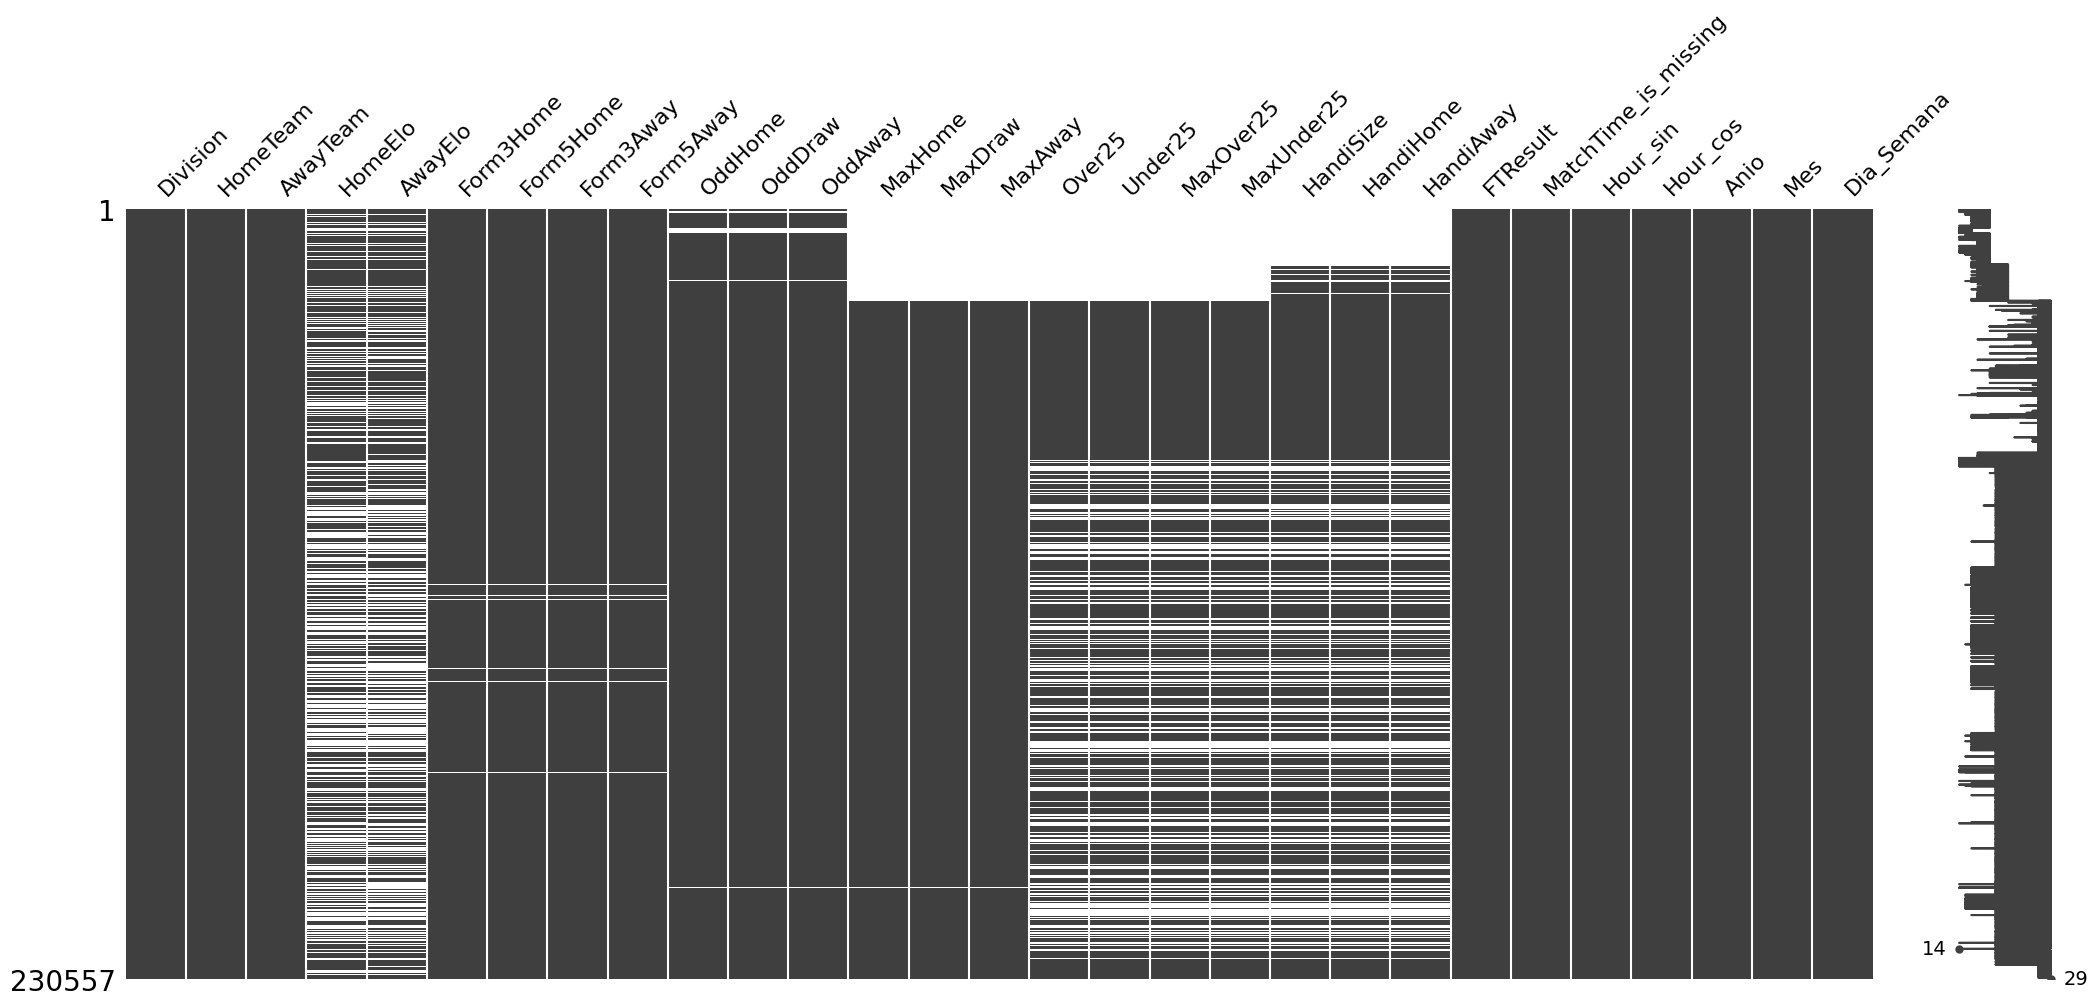

In [20]:
msno.matrix(datos_pre)

In [21]:
# Celda 4: Verificación Final
print("Resumen de valores faltantes en datos_pre:")
print(datos_pre.isnull().sum().sort_values(ascending=False).head(5))

Resumen de valores faltantes en datos_pre:
AwayElo       89029
HomeElo       88960
Under25       82160
MaxUnder25    82160
MaxOver25     82159
dtype: int64


# label enconder para ft result : 

In [22]:

# datos_pre = datos_pre.dropna(subset=['FTResult'])
le = LabelEncoder()
datos_pre['FTResult_encoded'] = le.fit_transform(datos_pre['FTResult'])

# 4. Verificamos la equivalencia para saber qué número corresponde a cada letra
mapping = dict(zip(le.classes_, le.transform(le.classes_)))

print("✅ Mapeo de resultados completado:")
print(mapping)
print("\nPrimeras filas del resultado codificado:")
print(datos_pre[['FTResult', 'FTResult_encoded']].head())

✅ Mapeo de resultados completado:
{'A': np.int64(0), 'D': np.int64(1), 'H': np.int64(2), nan: np.int64(3)}

Primeras filas del resultado codificado:
  FTResult  FTResult_encoded
0        H                 2
1        H                 2
2        A                 0
3        H                 2
4        D                 1


In [23]:
datos_pre.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Division,F1,F1,F2,F2,F2,F2,F2,F2,F2,F2,F2,F1,F1,F1,F2,F1,F1,F1,F1,F1
HomeTeam,Marseille,Paris SG,Wasquehal,Niort,Nimes,Nice,Laval,Chateauroux,Caen,Beauvais,Creteil,Toulouse,Nantes,Lyon,Ajaccio,Lille,Guingamp,Bordeaux,Auxerre,Sedan
AwayTeam,Troyes,Strasbourg,Nancy,Angers,Sochaux,Le Havre,Gueugnon,Martigues,Cannes,Montpellier,Lorient,Bastia,Lens,Rennes,Le Mans,Monaco,St Etienne,Metz,Sedan,Lyon
HomeElo,1686.34,1714.89,1465.08,1469.16,1449.91,1518.06,1496.87,1508.37,1521.6,1422.21,1439.34,1551.65,1664.36,1702.6,1470.87,1630.81,1578.51,1734.34,1635.58,1635.08
AwayElo,1586.57,1642.51,1633.8,1422.21,1575.12,1578.0,1541.08,1422.21,1461.5,1606.0,1491.14,1656.37,1730.89,1644.99,1477.89,1778.03,1620.74,1673.11,1624.22,1698.35
Form3Home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
Form5Home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
Form3Away,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
Form5Away,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
OddHome,1.65,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.15,1.6,NaN,2.75,2.25,1.65,1.7,2.1


In [24]:
# Comprobacion final antes de split/train/test
target_col = "FTResult_encoded"
print("Shape datos_pre:", datos_pre.shape)
print("Target presente:", target_col in datos_pre.columns)
if target_col in datos_pre.columns:
    y = datos_pre[target_col]
    X = datos_pre.drop(columns=[target_col])
else:
    y = None
    X = datos_pre.copy()

# Missing values
missing = datos_pre.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("\nMissing (top 10):")
print(missing.head(10) if not missing.empty else "Sin missing")

# Columnas no numericas
non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
print("\nColumnas no numericas:", non_numeric)

# Inf en numericas
num_cols = X.select_dtypes(include=[np.number]).columns
inf_count = np.isinf(X[num_cols].to_numpy()).sum() if len(num_cols) > 0 else 0
print("Inf en numericas:", inf_count)

# Duplicados
dup_rows = datos_pre.duplicated().sum()
print("Filas duplicadas:", dup_rows)

# Distribucion del target
if y is not None:
    print("\nDistribucion de clases (porcentaje):")
    print((y.value_counts(normalize=True) * 100).round(2).sort_index())

Shape datos_pre: (230557, 30)
Target presente: True

Missing (top 10):
AwayElo       89029
HomeElo       88960
Under25       82160
MaxUnder25    82160
MaxOver25     82159
Over25        82159
HandiAway     74106
HandiHome     74082
HandiSize     73824
MaxHome       27635
dtype: int64

Columnas no numericas: ['Division', 'HomeTeam', 'AwayTeam', 'FTResult']


Inf en numericas: 0
Filas duplicadas: 0

Distribucion de clases (porcentaje):
FTResult_encoded
0    28.87
1    26.51
2    44.62
3     0.00
Name: proportion, dtype: float64


## Split train test 

In [25]:
from sklearn.model_selection import train_test_split

# 1. Definimos 'X' (tus preguntas) y 'y' (tu respuesta/resultado)
# 'FTResult_encoded' es la que creamos antes con el LabelEncoder
X = datos_pre.drop(columns=['FTResult', 'FTResult_encoded']) 
y = datos_pre['FTResult_encoded']

# 2. Hacemos el split: 80% para entrenar y 20% para poner a prueba el modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"¡Listo! Tienes {X_train.shape[0]} partidos para entrenar y {X_test.shape[0]} para probar.")

¡Listo! Tienes 184445 partidos para entrenar y 46112 para probar.


## Resultados y análisis de missing / correlaciones ✅

**Resumen de acciones realizadas**

- Eliminadas columnas constantes y filas/columnas duplicadas.
- Clasificación heurística de columnas en **Antes (before)**, **Durante (during)** y **Posterior (after)** al partido.
- Estudio de patrones de valores faltantes por clasificación y por `Division`.
- Eliminadas columnas con >40% de valores faltantes (se listan en la salida de código) y filas con >50% de valores faltantes.
- Extraídas características simples: `EloDiff`, probabilidades implícitas de cuotas (`Odd_*_prob`), `ShotsDiff`, `GoalSum`, `GoalDiff`, `HomeWin/AwayWin/Draw`.

**Observaciones y correlaciones (interpretación)**

- 💡 *Patrón por `Division`*: las columnas con estadísticas detalladas del partido (disparos, tarjetas, córners) suelen estar mucho más completas en las divisiones superiores (ligas principales). Esto indica que la ausencia de datos está correlacionada con la **categoría de la competición**.

- 💡 *Patrón temporal*: en registros más antiguos es más frecuente encontrar campos faltantes (los datasets más recientes contienen más estadísticas por partido). Esto sugiere que el **tiempo** (fecha) es una fuente de missingness.

- 💡 *Odds y cobertura*: las columnas de cuotas (`OddHome/OddDraw/OddAway`) aparecen mayoritariamente en partidos con mercado de apuestas; su ausencia también está correlacionada con ligas/temporadas menos seguidas. Si vas a modelar probabilidades de resultado, **las cuotas son informative** pero no están disponibles para todos los casos.

- ⚠️ *Columnas eliminadas (>40% missing)*: muchas son columnas de detalle que aparecen solo en subsets (por ejemplo muchas columnas que empiezan por `C_` o columnas de probabilidades pre-calculadas). Se eliminaron automáticamente en este script; revisa la lista si quieres conservar alguna por contexto de negocio.

**Siguientes pasos recomendados**

1. Revisar la lista de columnas eliminadas y conservar manualmente alguna si se considera crítica para un uso específico.
2. Para filas eliminadas: si se necesita mantener más datos, considera imputación por `Division` o por `Season` en lugar de eliminarlas.
3. Normalizar nombres de equipos entre `Matches` y `EloRatings` para poder enriquecer partidos con ratings históricos sin perder filas por inconsistencias en nombres.
4. Añadir features más completas por equipo: medias móviles de Elo, forma agregada (goles esperados en últimas N jornadas), etc.

---

Si quieres, ejecuto la celda ahora y te muestro los outputs concretes (columnas eliminadas, número de filas quitadas, ejemplos de correlación por `Division`) y guardo las versiones: `Matches_clean.csv`, `Elo_clean.csv` y `EloLatest_byClub.csv`. ¿Quieres que ejecute la celda y te muestre los resultados? 🔍

In [26]:
# Visualizaciones para inspección previa a la limpieza 🔍

# - **Missingness:** usar `missingno` (matrix, bar, heatmap) para ver cobertura por columna y patrones por fila.
# - **Constantes / Baja variabilidad:** gráfico de `nunique` por columna (barras horizontales) para detectar columnas con 1 valor.
# - **Redundancia:** mapa de correlación y `clustermap` (solo numéricas) para detectar columnas altamente correlacionadas; además búsqueda de columnas idénticas.
# - **Duplicados:** número y ejemplo de filas duplicadas.

# Ejecuta estas visualizaciones antes de aplicar cambios automatizados para comprobar y tomar decisiones informadas.


# Modelos: 

## M1 

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Creamos los "cerebros" de nuestros modelos
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# 2. Entrenamos y guardamos resultados
resultados = {}

for nombre, modelo in modelos.items():
    # Entrenar el modelo con los datos de entrenamiento
    modelo.fit(X_train, y_train)
    # Hacer predicciones con los datos de prueba que el modelo NO conoce
    predicciones = modelo.predict(X_test)
    # Guardar el porcentaje de acierto (Accuracy)
    resultados[nombre] = accuracy_score(y_test, predicciones)
    
    print(f"✅ {nombre} entrenado.")

# Mostrar ranking de mejor a peor
print("\n--- RANKING DE ACCURACY ---")
for nombre, acc in sorted(resultados.items(), key=lambda x: x[1], reverse=True):
    print(f"{nombre}: {acc:.2%}")

ValueError: could not convert string to float: 'D1'

# metricas 

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Vamos a ver el detalle del mejor modelo (ejemplo con XGBoost)
mejor_modelo = modelos["XGBoost"]
pred_final = mejor_modelo.predict(X_test)

print("\n--- INFORME DE CLASIFICACIÓN (XGBoost) ---")
# Esto nos dice la precisión para cada clase (0, 1, 2)
print(classification_report(y_test, pred_final))

# Dibujar una matriz de confusión para ver visualmente los errores
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, pred_final), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción del Modelo')
plt.ylabel('Resultado Real')
plt.title('Matriz de Confusión: ¿Hacia dónde se van los errores?')
plt.show()

1. Sobre las Métricas
Accuracy: Es el % total de aciertos. Úsalo como guía rápida.

F1-Score (Recomendado): Si notas que el modelo casi nunca acierta los "Empates" (clase 1), el F1-Score te avisará. Es una métrica más honesta cuando una clase (como el Empate) ocurre menos que las otras.

Log-Loss: Esta métrica castiga al modelo si está muy "seguro" de una respuesta y se equivoca. Es la que usan los profesionales de apuestas.

2. Búsqueda de Hiperparámetros (Tuning)
Si quieres mejorar el Accuracy, tendrás que mover las "perillas" del modelo:

Random Forest: Prueba cambiando n_estimators (cuántos árboles usa) o max_depth (qué tan profundo/complejo es cada árbol).

XGBoost: El parámetro más importante es learning_rate (qué tan rápido aprende). Valores pequeños (0.01 a 0.1) suelen dar mejores resultados pero tardan más.

3. El factor "Empate"
No te desanimes si el Accuracy ronda el 45% - 55%. En el fútbol hay mucho azar. Un modelo que supere el 52% de forma constante suele ser considerado muy bueno, dado que hay 3 opciones posibles.

### Vamos a optimizar el XGBoost, ya que suele ser el más potente para datos de fútbol.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# 1. Definimos el "espacio de búsqueda" (qué perillas queremos mover)
parametros = {
    'n_estimators': [100, 200, 300],           # Número de árboles
    'max_depth': [3, 5, 7],                    # Qué tan profundo/complejo es cada árbol
    'learning_rate': [0.01, 0.05, 0.1],        # Qué tan rápido aprende (mejor lento pero seguro)
    'subsample': [0.7, 0.8, 0.9]               # % de datos que usa para cada paso
}

# 2. Creamos el buscador
# n_iter=10 le dice que pruebe 10 combinaciones al azar (para no tardar demasiado)
# cv=3 hace que pruebe cada combinación 3 veces para estar seguro
buscador = RandomizedSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    param_distributions=parametros,
    n_iter=10, 
    cv=3, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1  # Usa todos los núcleos de tu procesador para ir más rápido
)

# 3. ¡A buscar! (Esto puede tardar un par de minutos)
print("Buscando la mejor configuración... 🔎")
buscador.fit(X_train, y_train)

# 4. Ver los resultados
print("\n✅ ¡Mejor configuración encontrada!")
print(buscador.best_params_)

# Guardamos el mejor modelo ya ajustado
modelo_final = buscador.best_estimator_

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Hacemos las predicciones finales
y_pred_final = modelo_final.predict(X_test)

# 2. Calculamos las métricas clave
accuracy = accuracy_score(y_test, y_pred_final)
# Usamos 'macro' porque es multiclase (Local, Empate, Visitante)
f1 = f1_score(y_test, y_pred_final, average='macro')

print(f"--- RESULTADOS FINALES ---")
print(f"Puntería Total (Accuracy): {accuracy:.2%}")
print(f"Balance de Calidad (F1-Score): {f1:.2%}")

💡 Observaciones Finales para tu proyecto
A la hora de presentar o mejorar tu modelo, ten en cuenta esto:

El F1-Score es tu mejor amigo: En el fútbol, el Accuracy engaña. Si el modelo predice siempre que gana el local, tendrá un Accuracy decente pero será un modelo inútil. El F1-Score te dirá si también estás siendo capaz de detectar Empates y Victorias Visitantes.

Importancia de las Variables: Puedes ver qué columna fue la más importante para el modelo con modelo_final.feature_importances_. Casi siempre verás que el HomeElo y las Cuotas dominan el gráfico.

Sobre-ajuste (Overfitting): Si en el entrenamiento tienes 90% de acierto y en la prueba (test) tienes 50%, tu modelo se "memorizó" los datos. Para arreglarlo, baja el max_depth.